# Using the Fal mooring in situ data to calculate air-sea CO$_2$ gas fluxes #

## Introduction
This notebook explains how we can use the Fal mooring data to calculate air-sea CO$_2$ gas fluxes

### Load Relevant Modules
To begin with the required Python packages are loaded.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
# Install basemap-data-hires

### Loading the mooring data
Now we need to load the mooring data which is provided as a tab separated variable file (.tsv). And we can then view the first 5 rows of the dataset using the .head(5) command. Alternatively you can view the last 5 rows of the dataset using .tail(5).

In [2]:
# Load data file
region_data = pd.read_csv('Fal_mooring_fluxphar.tsv', sep='\t', index_col=0)
# Show small proportion of the data
region_data.head(5)

,Lon,Lat,Datetime,Date,Year,Month,Day,Hour,Minute,Second,salinity,sstskin_c,sstskin_k,windu10,windu10_moment2,pco2sw_corr_split,pressure_met,pco2_air_noaa_2018,pco2_sst
0,-5.027979,50.216161,14/09/2018 00:00,14/09/2018,2018,9,14,0,0,0,34.417400,16.709000,289.859000,2.057613,4.233772,500.019450,1024.1,401.3573,16.642000
1,-5.027979,50.216161,14/09/2018 00:00,14/09/2018,2018,9,14,0,0,0,34.417400,16.709000,289.859000,2.057613,4.233772,488.055048,1024.1,401.3573,16.642000
2,-5.027979,50.216161,14/09/2018 01:00,14/09/2018,2018,9,14,1,0,0,34.175967,16.681167,289.831167,2.057613,4.233772,550.944840,1023.9,401.3573,16.598000
3,-5.027979,50.216161,14/09/2018 02:00,14/09/2018,2018,9,14,2,0,0,33.936400,16.606000,289.756000,2.572016,6.615269,588.035046,1023.5,401.3573,16.514667
4,-5.027979,50.216161,14/09/2018 03:00,14/09/2018,2018,9,14,3,0,0,33.718900,16.542000,289.692000,2.572016,6.615269,627.313939,1022.9,401.3573,16.463000


### Preparing to Plot the Recorded Data
We want to plot a 'time series' of the data that was recorded. One way to show this is to plot 'Days since [first recording]' along the x-axis and the data along the y-axis. The cell below finds the number of days since the first measurement (technically it finds the number of seconds since the first recording and divides this by 86,400) and creates a new column in the Dataframe to show these values.

Note: if your own dataset doesn't have columns for 'Year', 'Month', 'Day', etc. then the below won't work and you need to add this to your dataset. This can be done in Excel (but better to do it Pythonically if possible to prevent Excel making changes to it's own formatting), and see example datasets for the required format.

In [3]:
# Initialise the new Dataframe column and fill with a hold value
region_data['Days_since'] = 'hold value'

# Produce a datetime object for the first recording 
# - the zeros in the line below show it's the first row (index starts at zero)
start_date = dt.datetime(region_data.loc[0,'Year'],region_data.loc[0,'Month'],region_data.loc[0,'Day'],
                            region_data.loc[0,'Hour'],region_data.loc[0,'Minute'],region_data.loc[0,'Second'])

# Loop over all rows in the Dataframe - i.e from 0 to the length of the Dataframe
for i in range(0,len(region_data)):
    # Get the date time object for the currently indexed recording - indexed by i
    future_date = dt.datetime(region_data.loc[i,'Year'],region_data.loc[i,'Month'],region_data.loc[i,'Day'],
                              region_data.loc[i,'Hour'],region_data.loc[i,'Minute'],region_data.loc[i,'Second'])
    
    # Find difference between current datetime and inital datetime
    day_diff = future_date - start_date
    
    # Fill Dataframe column with time difference in seconds (found using .total_seconds()) 
    # divided by 86400 (proportion of days that have passed)
    region_data.loc[i,'Days_since'] = day_diff.total_seconds()/(60*60*24)

We can filter the Dataframe to show just the 'Datetime' and 'Days_since' columns. Showing the head can give an idea if the previous cell worked - although a more thorough check is advised if possible depending on Dataframe size.

In [4]:
# Filter data to 'Datetime' and 'Days_since' columns and show first 5 rows.
region_data[['Datetime', 'Days_since']].head(5)

,Datetime,Days_since
0,14/09/2018 00:00,0.0
1,14/09/2018 00:00,0.0
2,14/09/2018 01:00,0.041667
3,14/09/2018 02:00,0.083333
4,14/09/2018 03:00,0.125


In [5]:
# Print column names
print("Column Names:", region_data.columns)

Column Names: Index(['Lon', 'Lat', 'Datetime', 'Date', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Second', 'salinity', 'sstskin_c', 'sstskin_k', 'windu10',
       'windu10_moment2', 'pco2sw_corr_split', 'pressure_met',
       'pco2_air_noaa_2018', 'pco2_sst', 'Days_since'],
      dtype='object')


In [6]:
import pandas as pd
import PyCO2SYS as pyco2
import numpy as np
import warnings

# Load data file
region_data = pd.read_csv('Fal_mooring_fluxphar.tsv', sep='\t', index_col=0)

# Calculate alkalinity and add it to the DataFrame
region_data['alkalinity'] = 889 + 37.9 * region_data['salinity']

# Assume pressure is 10 kPa for all measurements (surface or within the top 1 m)
pressure = 0

# Replace zero values with NaN in relevant columns before PyCO2Sys calculations
region_data['alkalinity'] = region_data['alkalinity'].replace(0, np.nan)
region_data['pco2sw_corr_split'] = region_data['pco2sw_corr_split'].replace(0, np.nan)

# Calculate carbonate system parameters using PyCO2Sys
results = pyco2.sys(
    par1=region_data['alkalinity'],
    par2=region_data['pco2sw_corr_split'],
    par1_type=1,  # Alkalinity
    par2_type=4,  # pCO2
    salinity=region_data['salinity'],
    temperature=region_data['sstskin_c'],
    pressure=pressure
)


# Unpack the results
region_data['pH'] = results['pH']
region_data['aragonite_saturation'] = results['saturation_aragonite']

# Save updated DataFrame to a new TSV file
region_data.to_csv('Fal_mooring_flux_updated.tsv', sep='\t')

# Display the first few rows of the updated DataFrame
print(region_data.head())


        Lon        Lat          Datetime        Date  Year  Month  Day  Hour  \
0 -5.027979  50.216161  14/09/2018 00:00  14/09/2018  2018      9   14     0   
1 -5.027979  50.216161  14/09/2018 00:00  14/09/2018  2018      9   14     0   
2 -5.027979  50.216161  14/09/2018 01:00  14/09/2018  2018      9   14     1   
3 -5.027979  50.216161  14/09/2018 02:00  14/09/2018  2018      9   14     2   
4 -5.027979  50.216161  14/09/2018 03:00  14/09/2018  2018      9   14     3   

   Minute  Second  ...   sstskin_k   windu10  windu10_moment2  \
0       0       0  ...  289.859000  2.057613         4.233772   
1       0       0  ...  289.859000  2.057613         4.233772   
2       0       0  ...  289.831167  2.057613         4.233772   
3       0       0  ...  289.756000  2.572016         6.615269   
4       0       0  ...  289.692000  2.572016         6.615269   

   pco2sw_corr_split  pressure_met  pco2_air_noaa_2018   pco2_sst  \
0         500.019450        1024.1            401.3573  16.

/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/PyCO2SYS/equilibria/p1atm.py:42: RuntimeWarning: divide by zero encountered in true_divide
  + (1776 / TempK) * IonS**2
/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/PyCO2SYS/equilibria/p1atm.py:42: RuntimeWarning: invalid value encountered in subtract
  + (1776 / TempK) * IonS**2
/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/PyCO2SYS/equilibria/p1atm.py:42: RuntimeWarning: invalid value encountered in add
  + (1776 / TempK) * IonS**2
/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/PyCO2SYS/equilibria/p1atm.py:64: RuntimeWarning: divide by zero encountered in true_divide
  pKSO4 = 647.59 / TempK - 6.3451 + 0.019085 * TempK - 0.5208 * np.sqrt(IonS)
/Users/sayooj/

### Plotting the Time Series  

The Matplotlib .subplots() function is ideal for this and I have used Seaborn to do the actual plotting - these two packages work well together as Seaborn is built on top of Matplotlib, and Seaborn also integrates easily with Pandas Dataframes. 

Producing nice looking plots with lovely axes labels and colors etc. can be fiddly, but you can refer to the documentation (and StackOverflow!) for hints and tips.

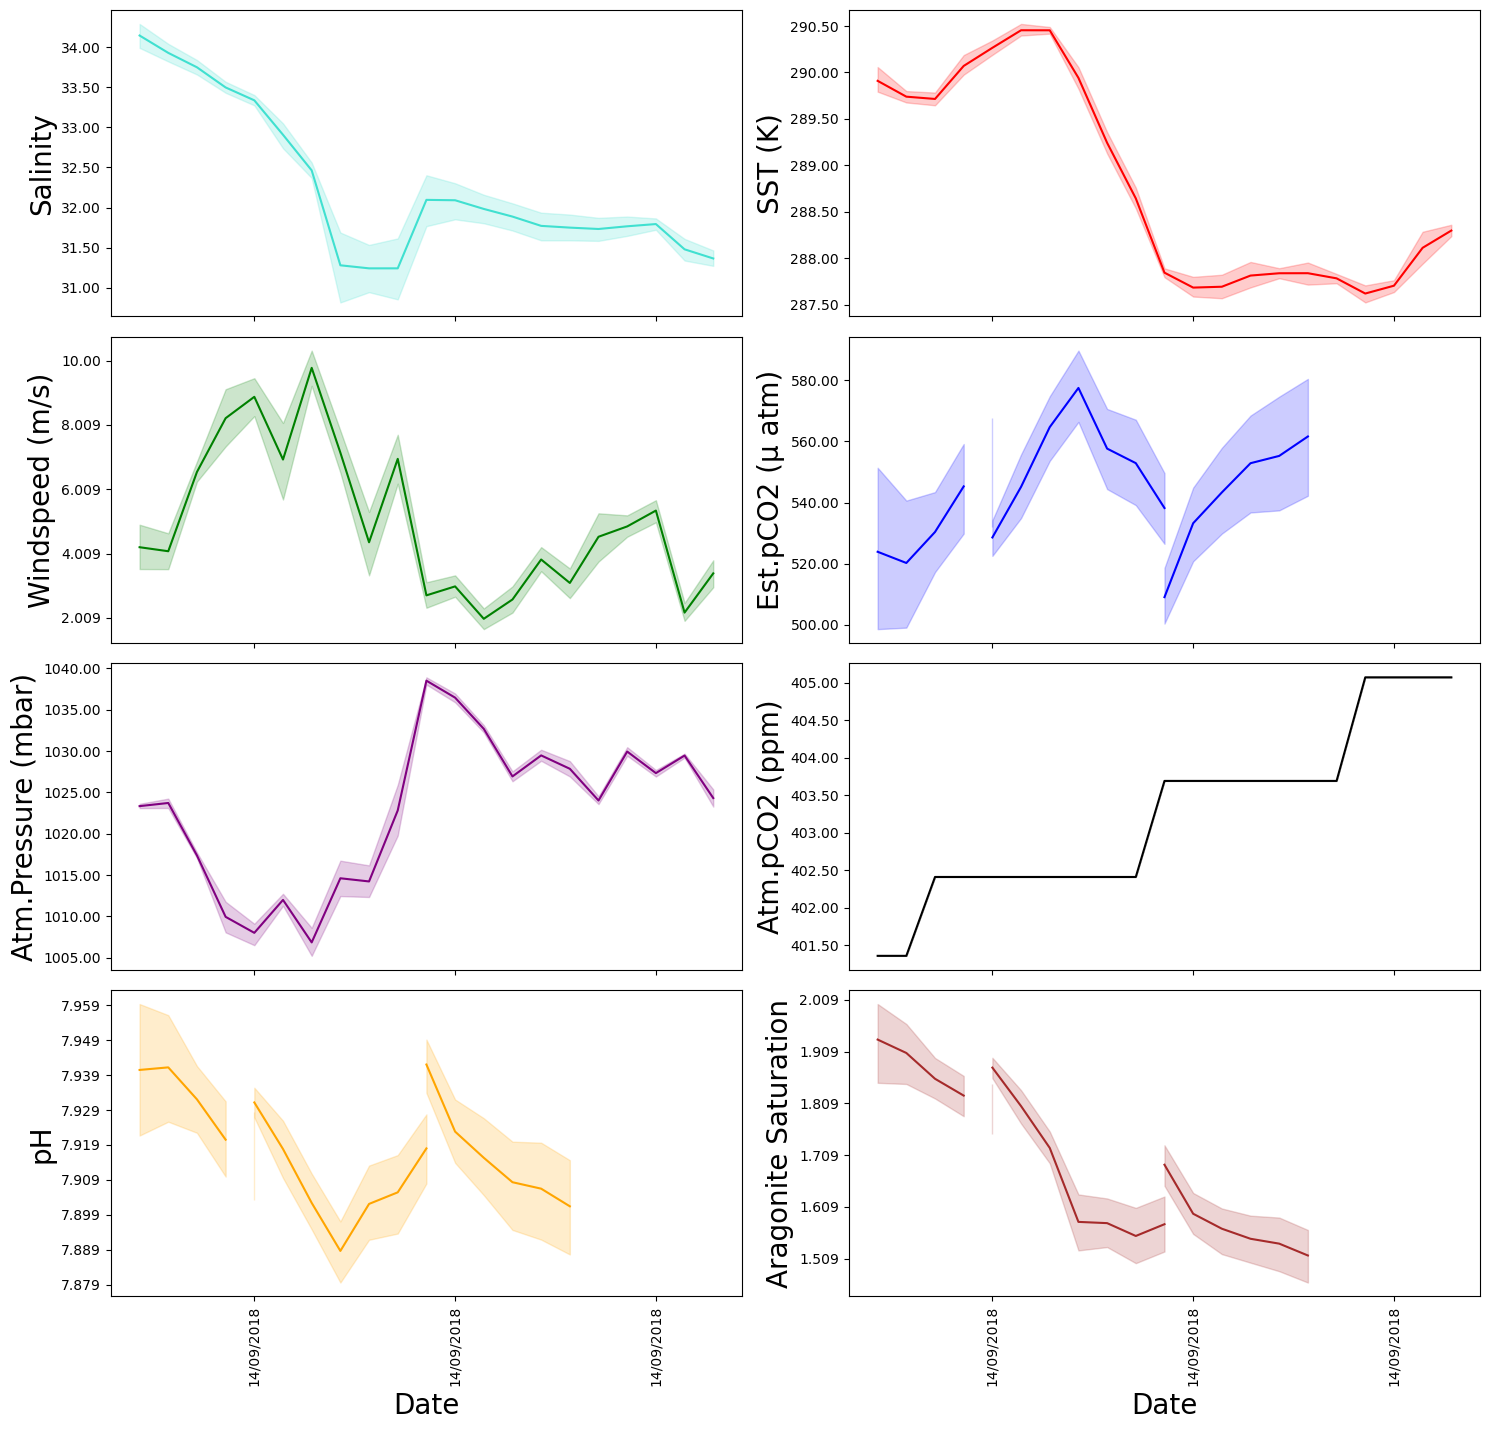

In [7]:
import matplotlib.dates as mdates
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# Load data file
region_data = pd.read_csv('Fal_mooring_flux_updated.tsv', sep='\t', index_col=0, nrows=500)

# Set up a figure with 4 axes on it. Sharex=True means all axes will share the bottom axes (can help with clarity)
fig,ax = plt.subplots(4,2, sharex=True)
# Set figure height and width
fig.set_figheight(15), fig.set_figwidth(15)

### PLOTTING THE DATA ### (- *s indicate a plot keyword below)
# These Seaborn commands state that we want a *lineplot*, where the *data* is coming 
# from our region_data Dataframe, and we chose the *x* & *y* columns that we want, as well
# as the axis (*ax*) we want to plot on (indexed by 0 at the top and 3 at the bottom)
sns.lineplot(data=region_data, x='Date', y='salinity', color='turquoise', ax=ax[0,0])
sns.lineplot(data=region_data, x='Date', y='sstskin_k', color='red', ax=ax[0,1])
sns.lineplot(data=region_data, x='Date', y='windu10', color='green', ax=ax[1,0])
sns.lineplot(data=region_data, x='Date', y='pco2sw_corr_split', color='blue', ax=ax[1,1], hue=region_data["pco2sw_corr_split"].isna().cumsum(), palette=["blue"]*sum(region_data["pco2sw_corr_split"].isna()), legend=False, markers=True)
sns.lineplot(data=region_data, x='Date', y='pressure_met', color='purple', ax=ax[2, 0])
sns.lineplot(data=region_data, x='Date', y='pco2_air_noaa_2018', color='black', ax=ax[2, 1])
sns.lineplot(data=region_data, x='Date', y='pH', color='orange', ax=ax[3, 0],hue=region_data["pH"].isna().cumsum(), palette=["orange"]*sum(region_data["pH"].isna()), legend=False, markers=True)
sns.lineplot(data=region_data, x='Date', y='aragonite_saturation', color='brown', ax=ax[3, 1],hue=region_data["aragonite_saturation"].isna().cumsum(), palette=["brown"]*sum(region_data["aragonite_saturation"].isna()), legend=False, markers=True)


# Use WeekdayLocator and DateFormatter to show only weekly dates on x-axis
date_fmt = mdates.DateFormatter('%d-%m-%Y')
week_locator = mdates.WeekdayLocator(byweekday=mdates.MO)
ax[2,0].xaxis.set_major_locator(week_locator)
ax[2,0].xaxis.set_major_formatter(date_fmt)
ax[2,1].xaxis.set_major_locator(week_locator)
ax[2,1].xaxis.set_major_formatter(date_fmt)

# Set x axis label
ax[3,0].set_xlabel('Date', fontsize = 20) 
ax[3,1].set_xlabel('Date', fontsize = 20) 
ax[3,0].set_xticklabels(region_data['Date'], rotation='vertical')
ax[3,1].set_xticklabels(region_data['Date'], rotation='vertical')



# Set y label for each axis
ax[0,0].set_ylabel('Salinity', fontsize = 20) 
ax[0,1].set_ylabel('SST (K)', fontsize = 20)
ax[1,0].set_ylabel('Windspeed (m/s)', fontsize = 20)
ax[1,1].set_ylabel('Est.pCO2 (µ atm)', fontsize = 20)
ax[2, 0].set_ylabel('Atm.Pressure (mbar)', fontsize = 20)
ax[2, 1].set_ylabel('Atm.pCO2 (ppm)', fontsize = 20)
ax[3, 0].set_ylabel('pH', fontsize = 20)
ax[3, 1].set_ylabel('Aragonite Saturation', fontsize = 20)


# Changes how axis ticks are displayed for last two axes
ax[0,0].yaxis.set_major_formatter('{x:9<5.2f}')
ax[0,1].yaxis.set_major_formatter('{x:9<5.2f}')
ax[1,0].yaxis.set_major_formatter('{x:9<5.2f}')
ax[1,1].yaxis.set_major_formatter('{x:9<5.2f}')
ax[2,0].yaxis.set_major_formatter('{x:9<5.2f}')
ax[2,1].yaxis.set_major_formatter('{x:9<5.2f}')
ax[3,0].yaxis.set_major_formatter('{x:9<5.2f}')
ax[3,1].yaxis.set_major_formatter('{x:9<5.2f}')

# Set a tight layout to remove extra space around the plots
fig.tight_layout()
# Reduce gap between top of figure and the title
fig.subplots_adjust(top=0.95)

# Show figure!
plt.show()

